# 使用 TensorFlow 做定长文本识别 
环境 `tensorflow2.1`, `CUDA 10.1` and `cuDNN 7.6`       
`tensorflow2.1` 版本已经把 `fit_generator` 合并到 `fit` 了

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 探索数据
预处理数据可以看 `preprocess.py`

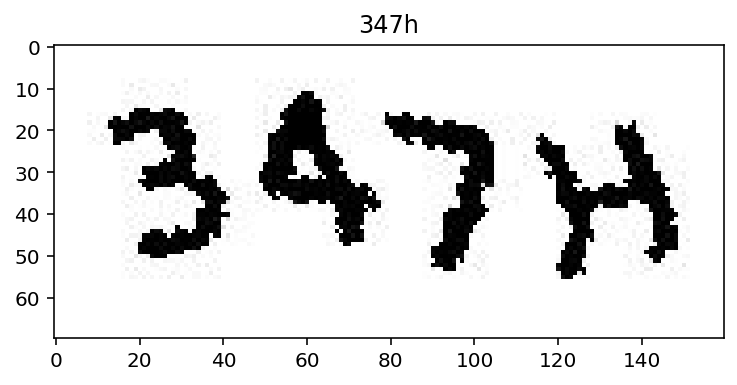

In [2]:
from config import labels_to_text
from data_sequence import ShiXinSequence

sx_sequence = ShiXinSequence('./dataset/binary')

(x_train,y_train,_,_),_ = sx_sequence[0]
plt.title(labels_to_text(y_train[1]))
plt.imshow(np.squeeze(x_train[1],-1),cmap='gray')

## ShiXin 模型



In [3]:
from config import OUTPUT_PATH,TARGET_PATH
from network.model import ShiXinModel


# 创建和编译模型
sx_train_model = ShiXinModel()
sx_train_model.compile()

callbacks = sx_train_model.get_callbacks(logdir=OUTPUT_PATH,checkpoint=TARGET_PATH, monitor="loss",verbose=1)

## 训练模型

In [4]:
h = sx_train_model.fit(x=sx_sequence,epochs=15,callbacks=callbacks,verbose=1)

  ...
    to  
  ['...']
Train for 345 steps
Epoch 1/15
345/345 [==============================] - 53s 153ms/step - loss: 15.1970
Epoch 2/15
345/345 [==============================] - 45s 129ms/step - loss: 12.4417
Epoch 3/15
345/345 [==============================] - 45s 131ms/step - loss: 2.1548
Epoch 4/15
345/345 [==============================] - 47s 137ms/step - loss: 0.4530
Epoch 5/15
345/345 [==============================] - 46s 134ms/step - loss: 0.1768
Epoch 6/15
345/345 [==============================] - 47s 136ms/step - loss: 0.0864
Epoch 7/15
345/345 [==============================] - 47s 135ms/step - loss: 0.0336
Epoch 8/15
345/345 [==============================] - 48s 138ms/step - loss: 0.0099
Epoch 9/15
345/345 [==============================] - 48s 138ms/step - loss: 0.0066
Epoch 10/15
345/345 [==============================] - 48s 140ms/step - loss: 0.0036
Epoch 11/15
345/345 [==============================] - 49s 142ms/step - loss: 0.0025
Epoch 12/15
345/345 [======

## 预测
因为 ctc 的训练和预测输入和输出不一样,所以需要新建一个模型来载入已经训练好的权重

In [5]:
sx_predict_model = ShiXinModel()
sx_predict_model.compile()
sx_predict_model.load_checkpoint(TARGET_PATH)

In [6]:
out = sx_predict_model.predict(x=np.array([x_train[1]]))
out 

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


array([[ 3,  4,  7, 17, 12]], dtype=int64)

In [7]:
from pathlib import Path

from PIL import Image


imgs = list(Path('./dataset/val_binary').glob('*'))

x_v = np.array( [np.expand_dims(np.array(Image.open(filename)), -1) / 255.0 for filename in imgs])
out = sx_predict_model.predict(x=x_v)
for idx ,val in enumerate(out):
    print(f'y_pred:{labels_to_text(val)} y_true:{imgs[idx].name[:4]}')

y_pred:aafe y_true:aafe
y_pred:bxmp y_true:bxmp
y_pred:f4rhc y_true:f4rh
y_pred:fmew y_true:fmew
y_pred:gemt y_true:gemt
y_pred:hl8n y_true:hl8n
y_pred:mrhu y_true:mrhu
y_pred:rvayc y_true:rvay
y_pred:sdtn y_true:sdtn
y_pred:txy7c y_true:txy7
y_pred:y7m8 y_true:y7m8


> 这里可以看到 `aafe` 也正确识别出来了, 如果解码算法有问题的话, 可能只能识别出一个 `a` 字符

## 模型结构

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


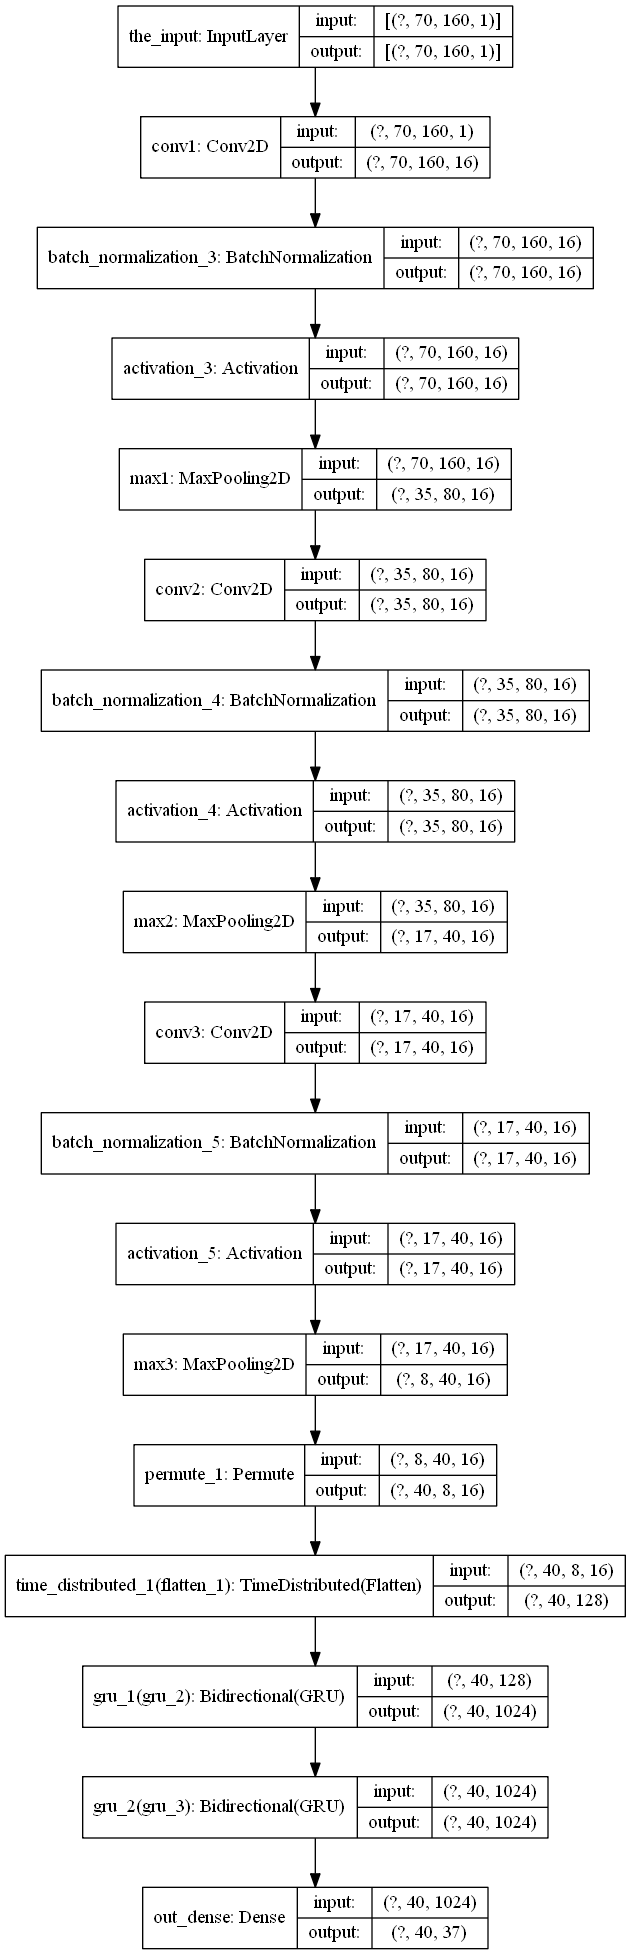

In [8]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(sx_predict_model.model, to_file='ctc.png', show_shapes=True)
Image('ctc.png')

In [9]:
sx_predict_model.model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 70, 160, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 70, 160, 16)       160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 70, 160, 16)       64        
_________________________________________________________________
activation_3 (Activation)    (None, 70, 160, 16)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 35, 80, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 35, 80, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 35, 80, 16)        64  

## 导出模型

In [10]:
!python export.py

Export path: Shixin\1
Already saved a model, cleaning up
Saved mode: Shixin\1


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 使用 TensorFlow Serving 和 Docker 部署模型

In [11]:
!docker run -p 8501:8501 --mount type=bind,source=d:/workspace/ocr_shixin/Shixin/,target=/models/Shixin -e MODEL_NAME=Shixin -t -d tensorflow/serving

110c22704b30e9ae10205ce08c126ba1aad8cdc92a0a3313e2855903b9567b48


## Python 客户端示例

In [13]:
import requests
from tensorflow.keras import backend as K


url = 'http://localhost:8501/v1/models/Shixin:predict'
data = {
    "instances":x_v.tolist()
}

response = requests.post(url,json=data)
out = np.array(response.json()['predictions'])
out = K.get_value(
            K.ctc_decode(
                out,
                np.ones(out.shape[0]) * out.shape[1]
            )[0][0]
        )

for i in out:
    print(labels_to_text(i))

aafe
bxmp
f4rhc
fmew
gemt
hl8n
mrhu
rvayc
sdtn
txy7c
y7m8
